Using emcee to find the best-fit line

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

In [3]:
#load data from Harris+Atlas
M_HA    = np.loadtxt(path1+"/data_Atlas_Harris13.txt",usecols=(0))
N_GC_HA = np.loadtxt(path1+"/data_Atlas_Harris13.txt",usecols=(1))

NameError: name 'path1' is not defined

In [5]:
N_bGC_HA = np.full_like(N_GC_HA,0)
fblue = lambda M_h: (M_h/1e10)**(-0.07) if (M_h > 1e10 and M_h <= 1e13) else 1 if (M_h <= 1e10) else 0.5

for i in range (1,len(N_GC_HA)):
    N_bGC_HA[i] = N_GC_HA[i]*fblue(M_HA[i])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


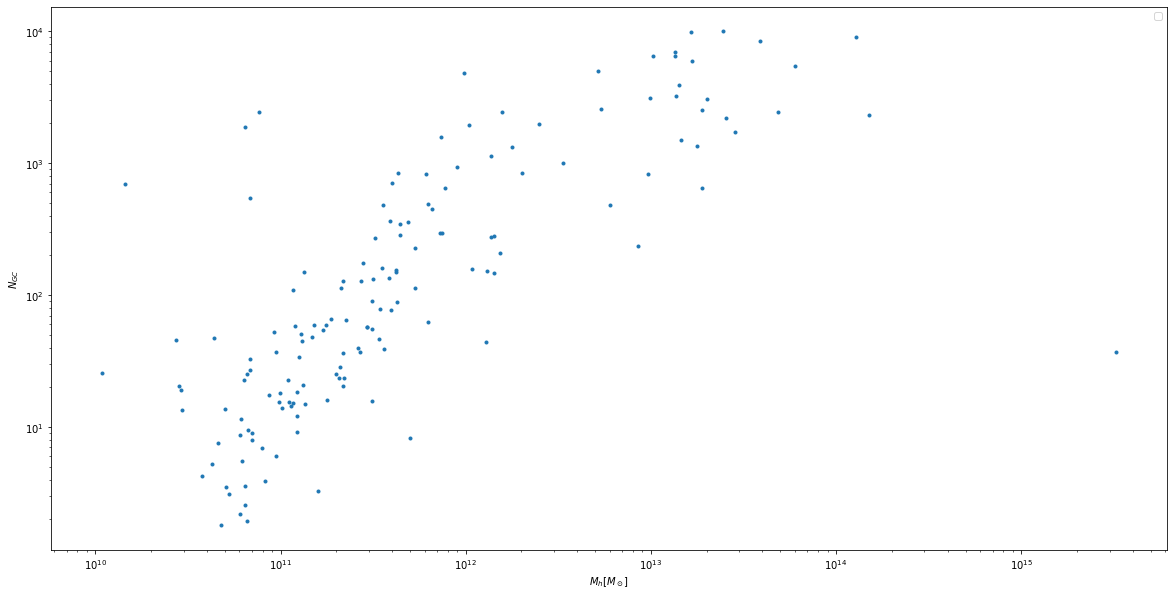

In [8]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)
plt.loglog(M_HA,N_bGC_HA,'.')
plt.xlabel('$M_h [M_\odot]$')
plt.ylabel('$N_{GC}$')
plt.legend()

In [146]:
def model(theta, mass=M_HA):
    a1, a2 = theta  #parameters in the model
    model = a1*(mass/1e10)**a2
    return model

In [124]:
def lnlike(theta, x, y, yerr):
    lnlike = -0.5*np.sum(((y-model(theta,x))/yerr)**2)
    return lnlike

In [147]:
# the things we know (fact/conditions to the parameters)
def lnprior(theta):
    a1, a2= theta
    if 1 < a1 < 100 and 0.05 < a2 < 1:
         return 0.0
    else:
        return -np.inf

In [148]:
# the function as lnprior output + lnlike output
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [172]:
err      = 0.00005*N_bGC_HA #error of the temperature array, set 5%
data     = (M_HA, N_bGC_HA, err)
nwalkers = 500
niter    = 5000
initial  = np.array([10, 0.75]) # initial set of values of the parameters (guess)
ndim     = len(initial)

#stepping from one place to the next, generate N-dimensional parameters space close to the current location
p0       = [np.array(initial) + 1e-7*np.random.randn(ndim) for i in range(nwalkers)]

In [173]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [174]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


<ipython-input-124-e9e5e73c6857>:2: RuntimeWarning: divide by zero encountered in true_divide
  lnlike = -0.5*np.sum(((y-model(theta,x))/yerr)**2)
/home/ngoc/anaconda3/envs/project/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Running production...


In [175]:

def plotter(sampler,mass=M_HA,N=N_bGC_HA):
    plt.xscale("log")
    plt.yscale("log")
    plt.ion()
    plt.plot(mass,N,'.',label='Change in N_GC')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(mass, model(theta, mass), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('$M_h [M_\odot]$')
    plt.ylabel('$N_{GC}$')
    plt.legend()
    plt.show()

AttributeError: This method only works with the ScalarFormatter

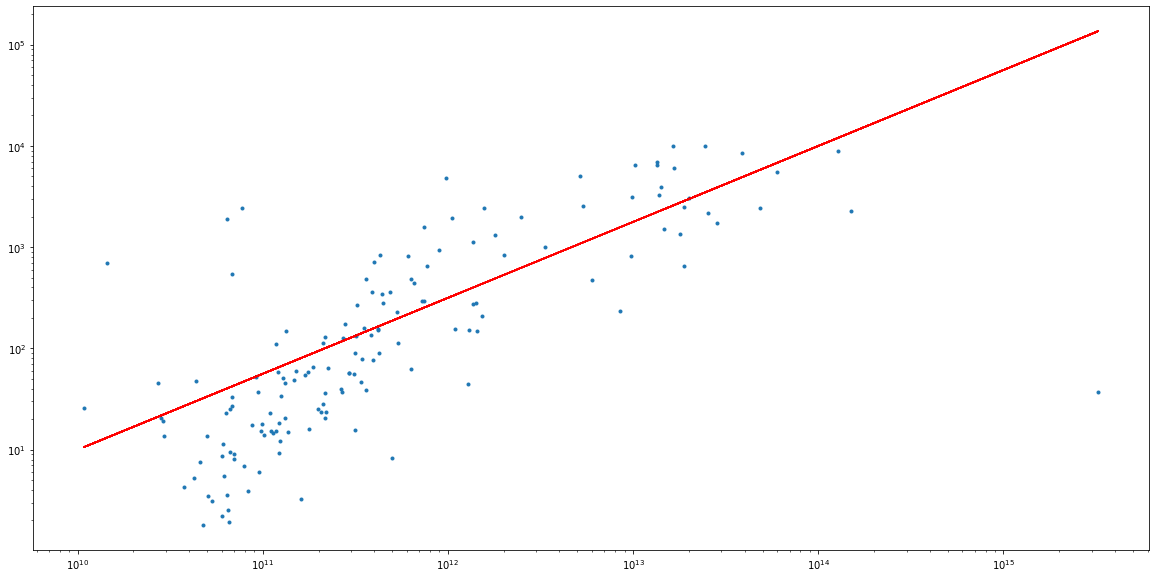

In [176]:
plotter(sampler)

In [159]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]
#value of each parameter, highest likelihood model 

array([10.00000003,  0.74999997])

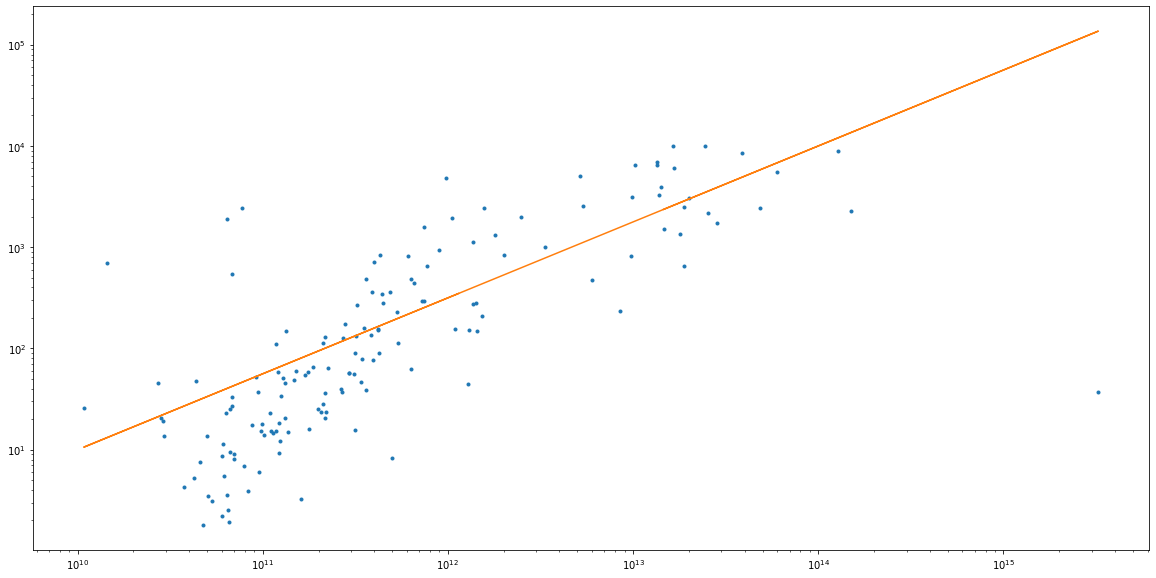

Theta max:  [10.00000003  0.74999997]


In [160]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.loglog(M_HA,N_bGC_HA,'.',label='Change in T')
plt.plot(M_HA,best_fit_model,'-',label='Highest Likelihood Model')
plt.show()
print ('Theta max: ',theta_max)

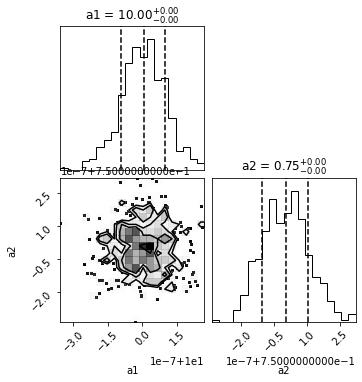

In [161]:
#posterior spread: spreading between the parameters + uncertainties
labels = ['a1','a2']
fig = corner.corner(samples,
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True
                    ,quantiles=[0.16, 0.5, 0.84])